In [1]:
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM

In [3]:
from tensorflow.python.keras.engine import data_adapter

def _is_distributed_dataset(ds):
    return isinstance(ds, data_adapter.input_lib.DistributedDatasetSpec)

data_adapter._is_distributed_dataset = _is_distributed_dataset

In [4]:
import yfinance as yf

stock_name = 'TATAMOTORS.NS'
ticker = yf.Ticker(stock_name)


<Axes: title={'center': 'TATAMOTORS.NS'}, xlabel='Date'>

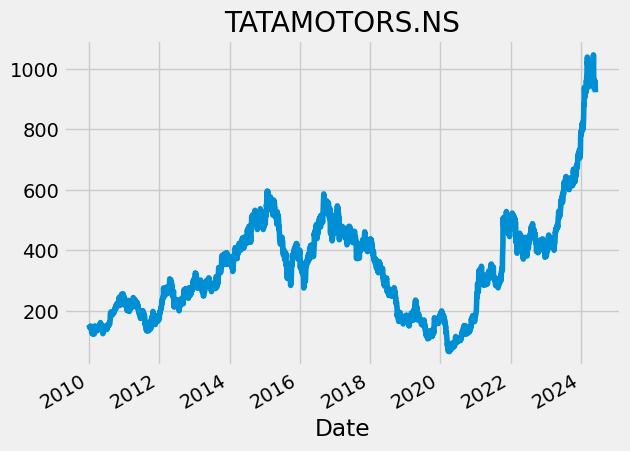

In [5]:
import datetime

startDate = datetime.datetime(2010, 1, 1)
endDate = datetime.datetime(2024, 6, 1)

data = yf.Ticker(stock_name)
df = data.history(start=startDate, end=endDate)
df['Close'].plot(title=stock_name)

In [6]:
data = df.filter(['Close'])
dataset = data.values

training_data_len = math.ceil(len(dataset)*0.8)
training_data_len

2844

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(dataset)

In [8]:
trained_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(trained_data)):
    x_train.append(trained_data[i-60:i,0])
    y_train.append(trained_data[i,0])

In [9]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [11]:
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
print(x_train,y_train)

[[[0.08921358]
  [0.08650358]
  [0.0867388 ]
  ...
  [0.07594582]
  [0.07627513]
  [0.08002965]]

 [[0.08650358]
  [0.0867388 ]
  [0.08150701]
  ...
  [0.07627513]
  [0.08002965]
  [0.08074479]]

 [[0.0867388 ]
  [0.08150701]
  [0.08231623]
  ...
  [0.08002965]
  [0.08074479]
  [0.07937097]]

 ...

 [[0.24126253]
  [0.24192266]
  [0.24852427]
  ...
  [0.25553208]
  [0.25573523]
  [0.24481721]]

 [[0.24192266]
  [0.24852427]
  [0.23978984]
  ...
  [0.25573523]
  [0.24481721]
  [0.24476641]]

 [[0.24852427]
  [0.23978984]
  [0.23638748]
  ...
  [0.24481721]
  [0.24476641]
  [0.24593441]]] [0.08074479 0.07937097 0.08336075 ... 0.24476641 0.24593441 0.24948912]


In [14]:
model.fit(x_train, y_train)

87/87 [==============================] - 6s 36ms/step - loss: 0.0038


In [15]:
test_data = scaled_data[training_data_len - 60:, :]

x_test = []
y_test = dataset[training_data_len:,:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [16]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [17]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [18]:
rmse = np.sqrt( np.mean(predictions - y_test)**2)
print(rmse)

5.042815518278613


C:\Users\mukul\AppData\Local\Temp\ipykernel_11212\4192782412.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


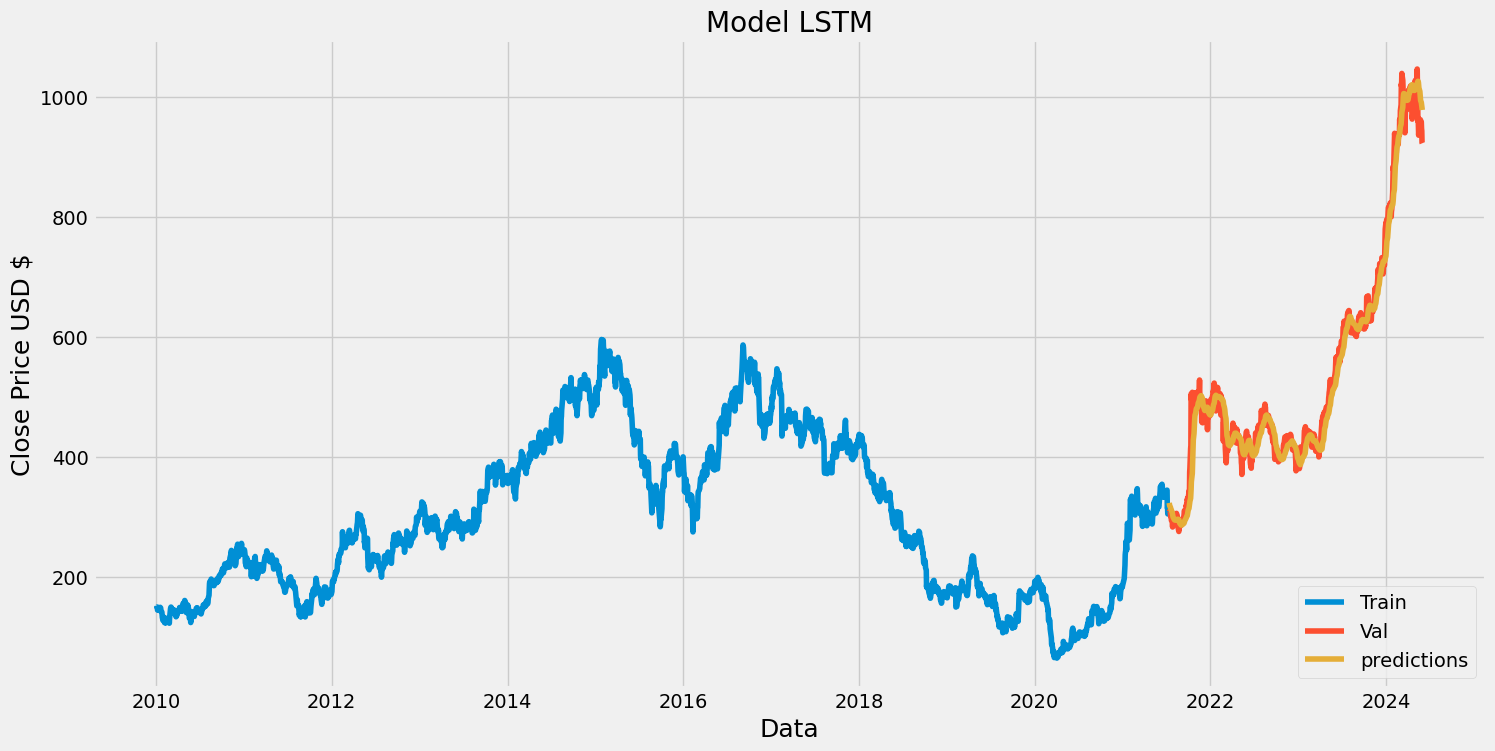

In [19]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title("Model LSTM")
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD $', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'predictions'], loc='lower right')
plt.show()

In [21]:
last_60_days = data[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
x_last_60_days = []
x_last_60_days.append(last_60_days_scaled)
x_last_60_days =  np.array(x_last_60_days)

x_last_60_days = np.reshape(x_last_60_days, ( x_last_60_days.shape[0], x_last_60_days.shape[1], 1))

price_predict = model.predict(x_last_60_days)
pred_price = scaler.inverse_transform(price_predict)
print(pred_price)

# get data of the most recent date
todays_data = ticker.history(period='1d')

print(todays_data)

[[974.3106]]
                                 Open    High         Low  Close    Volume  \
Date                                                                         
2024-05-31 00:00:00+05:30  931.650024  937.25  920.099976  923.0  14289102   

                           Dividends  Stock Splits  
Date                                                
2024-05-31 00:00:00+05:30        0.0           0.0  
